算法流程：

1.对不同曝光图做直方图匹配(hist_match)，得到亮度比较接近的两张图

2.算出直方图匹配后两张图之间的光流，把一张图warp到参考图上，和参考图对齐。

3.进行误匹配检测、过曝光欠曝光区域检测。对过曝光欠曝光区域(cliped_region)的光流进行插值，对occlusion区域(误匹配区域-cliped_region)用参考图对应区域进行填充。

4.把三张对齐了的图做曝光融合。

以两张图的匹配为例：

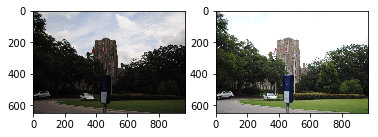

In [55]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

ref=cv2.imread('2.jpg')#参考图
low=cv2.imread('3.jpg')#低曝光图

plt.subplot(121)
plt.imshow(low[:,:,[2,1,0]])
plt.subplot(122)
plt.imshow(ref[:,:,[2,1,0]])

###开始两张图是没有对齐的

# 1.直方图匹配

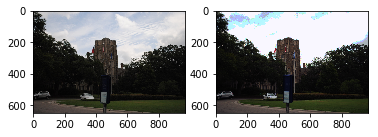

In [56]:
#直方图匹配，把 ref 的亮度调节成和　low 比较接近，方便后面计算光流更稳定
def his_match(src, dst):
    res = np.zeros_like(dst)
    # cdf 为累计分布
    cdf_src = np.zeros((3, 256))
    cdf_dst = np.zeros((3, 256))
    cdf_res = np.zeros((3, 256))
    kw = dict(bins=256, range=(0, 256), density=True)
    for ch in range(3):
        his_src, _ = np.histogram(src[:, :, ch], **kw)
        hist_dst, _ = np.histogram(dst[:, :, ch], **kw)
        cdf_src[ch] = np.cumsum(his_src)
        cdf_dst[ch] = np.cumsum(hist_dst)
        index = np.searchsorted(cdf_src[ch], cdf_dst[ch], side='left')
        np.clip(index, 0, 255, out=index)
        res[:, :, ch] = index[dst[:, :, ch]]
        his_res, _ = np.histogram(res[:, :, ch], **kw)
        cdf_res[ch] = np.cumsum(his_res)
    return res, (cdf_src, cdf_dst, cdf_res)


ref2low, _ = his_match(low, ref)
plt.subplot(121)
plt.imshow(low[:,:,[2,1,0]])
plt.subplot(122)
plt.imshow(ref2low[:,:,[2,1,0]])
#左边是low,右边是把ref调节亮度后的ref2low　这两张仍是没有对齐的

# 2.算出low到ref2low的光流，把low根据光流warp到和参考图ref对齐

计算光流用的"Fast Optical Flow using Dense Inverse Search"，测试的时候发现对有些很暗场景效果不太稳定，但是优点是速度很快。

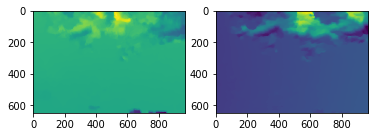

In [57]:
low_gray=cv2.cvtColor(low,cv2.COLOR_BGR2GRAY)
ref2low_gray=cv2.cvtColor(ref2low,cv2.COLOR_BGR2GRAY)
inst = cv2.DISOpticalFlow_create(cv2.DISOpticalFlow_PRESET_MEDIUM)
inst.setUseSpatialPropagation(True)
flow1 = inst.calc(low_gray,ref2low_gray, None)#算出forward光流，方面后面与backward光流一起计算误匹配区域
flow2 = inst.calc(ref2low_gray, low_gray, None)#算出backward光流，准备后面的warp

plt.subplot(121)
plt.imshow(flow2[:,:,0])#　x方向位移
plt.subplot(122)
plt.imshow(flow2[:,:,1])# y方向位移

然后用flow2做backward warping,把low warp到ref 上，这样低曝图就和参考图基本对齐：

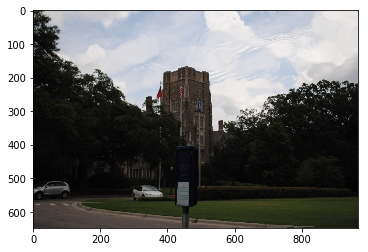

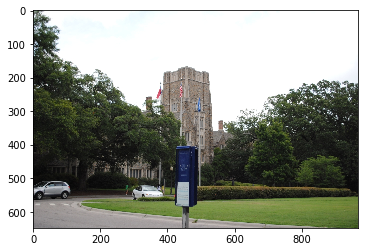

In [58]:
row,col,_=flow2.shape
y,x=np.meshgrid(np.arange(0,col),np.arange(0,row))

yy=y+flow2[:,:,0]
xx=x+flow2[:,:,1]
yy=yy.astype(np.float32)
xx=xx.astype(np.float32)
result=cv2.remap(low,yy,xx,interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT)
plt.figure()
plt.imshow(result[:,:,[2,1,0]])#把low warp以后的图,基本与ref 对齐
plt.figure()
plt.imshow(ref[:,:,[2,1,0]])#ref的原图

# 3.检测误匹配区域和cliped_region(过曝光和欠曝光区域)，特殊处理

虽然现在基本把low和ref对齐了，但是对于一些区域可能存在误匹配。误匹配的原因主要有：

１．过曝光和欠曝光区域(cliped_region)缺失信息，即使直方图匹配以后也和需要匹配的区域差距较大，导致计算出光流有误，从而warp的时候把对不上的区域warp过来。（但是这组图像的例子里，好像误匹配区域的影响不是很大。）

２．occlusion区域。就是low图像中没有而ref图像中存在的区域，例如图像左下方的行人，在low图像中不存在，warp时无法从low图像中获取到那个行人的内容。

需要首先检测出误匹配，然和区分出对这两种情况做特殊处理，

首先计算误匹配区域：
根据公式
|flow1+flow2|**2>=0.01*|flow1**2+flow2**2|+0.5检测光流的误匹配，参考论文"UnFlow: Unsupervised Learning of Optical Flow with a Bidirectional Census Loss"检测遮挡区域的方式："We mark pixels as becoming occluded whenever
the mismatch between these two flows is too large"……找到这一句下面有公式就是现在算法使用的方法


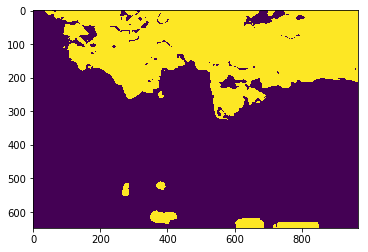

In [59]:
row,col,_=flow1.shape
y,x=np.meshgrid(np.arange(0,col),np.arange(0,row))
yy=y+flow2[:,:,0]
xx=x+flow2[:,:,1]
yy=yy.astype(np.float32)
xx=xx.astype(np.float32)
flow1_to_flow2 = cv2.remap(flow1,yy,xx,interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REPLICATE)

diff=flow2+flow1_to_flow2
lhs=np.sum(diff**2,axis=2)
rhs=0.01*(np.sum(flow2**2,axis=2)+np.sum(flow1_to_flow2**2,axis=2))+0.5
zz=lhs>=rhs #zz是一个误匹配区域的mask
plt.imshow(zz)#可以看到右下方的行人、过曝区域的天空处的光流都是误匹配

需要对误匹配区域中的两个组成部分　１．clipped和２．occlusion区域分开处理：

1.clipped:由于是过度曝光或者太暗区域，这个区域光流算得不准会导致warp后的图和参考图在那一块内容对不上(这组图还能对得上都是天空，但是有的组图会内容对不上),所以需要预测clipped区域的正确的光流，把错误的光流mask掉，对这块光流进行插值。

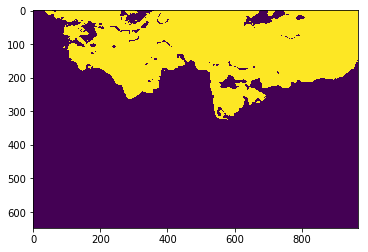

In [60]:
cliped_region=(ref_gray<0.02*255)|(ref_gray>0.98*255)#算出ref(参考图)中所有过度曝光和太暗区域
new_cliped=zz&cliped_region#算出误匹配区域中存在的cliped区域
plt.imshow(new_cliped)#过度曝光的天空

对过曝区域的光流做插值,目前简单的使用全图光流的平均值进行填充：

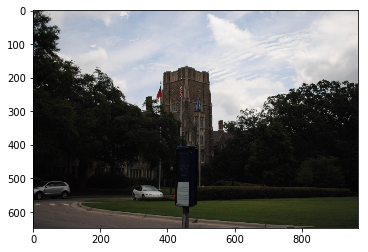

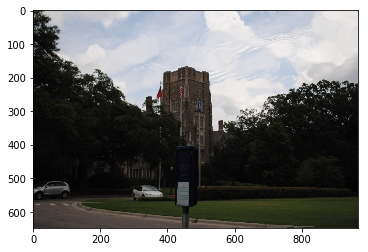

In [61]:
flow2[new_cliped,:]=np.mean(np.mean(flow2,axis=0),axis=0)#用平均值进行填充
yy=y+flow2[:,:,0]
xx=x+flow2[:,:,1]
yy=yy.astype(np.float32)
xx=xx.astype(np.float32)
#warp
result_2=cv2.remap(low,yy,xx,interpolation=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT)
plt.figure()
plt.imshow(result_2[:,:,[2,1,0]])#改进后的warp图，相比原始的warp图，改进后的在天空处更自然一些(右上角)
plt.figure()
plt.imshow(result[:,:,[2,1,0]])#之前的warp图

2.occlusion:对于occlusion区域，即是ref图中左下方有行人的区域。由于low图中没有行人这部分图像，所以需要用ref2low中对应图像进行填充，
直接填充会存在比较明显的边缘，使用多尺度融合的方式进行填充(blend.py中的huandiao函数(huandiao=="换掉"))

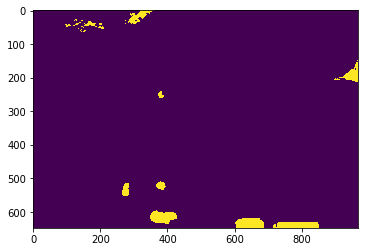

In [62]:
#从误匹配区域zz中检测出occlusion区域
new_zz=zz^new_cliped#从zz中剔除之前检测出new_clipped区域
plt.imshow(new_zz)#检测出occlusion区域，例如左下方的行人，对这些区域用ref2low对应部分进行图像填充

In [63]:
def huandiao(A,B,occ):  
    #################################################
    A=A.astype(np.float32)
    B=B.astype(np.float32)
    print(A.dtype)
    occ=np.float32(occ)
    row,col,_=A.shape
    col_list=[col,col//2,col//4,col//8,col//16,col//32]
    row_list=[row,row//2,row//4,row//8,row//16,row//32]

    G = A.copy()
    gpA = [G]
    for i in range(5):
        row,col,_=G.shape
        G=cv2.resize(G,(col_list[i+1],row_list[i+1]))
        gpA.append(G)
    
    # generate Gaussian pyramid for B
    G = B.copy()
    gpB = [G]
    for i in range(5):
        row,col,_=G.shape
        G=cv2.resize(G,(col_list[i+1],row_list[i+1]))
        gpB.append(G)
    
    # generate Laplacian Pyramid for A
    lpA = [gpA[5]]
    for i in range(5,0,-1):
        row,col,_=gpA[i].shape
        GE=cv2.resize(gpA[i],(col_list[i-1],row_list[i-1])) 
        L=gpA[i-1]-GE
        lpA.append(L)
    
    # generate Laplacian Pyramid for B
    lpB = [gpB[5]]
    for i in range(5,0,-1):
        row,col,_=gpB[i].shape
        GE=cv2.resize(gpB[i],(col_list[i-1],row_list[i-1]))
        L=gpB[i-1]-GE
        lpB.append(L)
    
    LS = []
    for la,lb in zip(lpA,lpB):
        rows,cols,dpt = la.shape
        print(la.shape)
        occ_temp=cv2.resize(occ,(cols,rows))
        occ_temp_3=np.zeros_like(la)
        occ_temp_3[:,:,0]=occ_temp.copy()
        occ_temp_3[:,:,1]=occ_temp.copy()
        occ_temp_3[:,:,2]=occ_temp.copy()
        ls=la*(1-occ_temp_3)+lb*occ_temp_3
        LS.append(ls)
    
    # now reconstruct
    ls_ = LS[0]
    for i in range(1,6):
        row,col,_=ls_.shape
        ls_ = cv2.resize(ls_,(col_list[5-i],row_list[5-i]))#
        ls_ = ls_+LS[i]#

# image with direct connecting each half

    return np.clip(ls_,0,255).astype(np.uint8)

float32
(20, 30, 3)
(40, 60, 3)
(81, 121, 3)
(162, 242, 3)
(324, 484, 3)
(648, 968, 3)


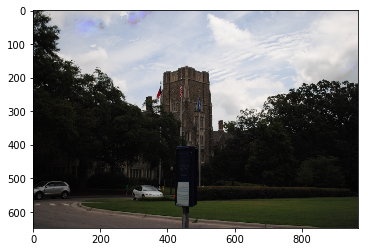

In [65]:
result_3=huandiao(result_2,ref2low,new_zz)#对result_2上new_zz区域的图像，用ref2low对应区域进行填充
plt.imshow(result_3[:,:,[2,1,0]])#可以看到下方车左边出现了绿色人影。

这样就得到warp以后的low_warp图像。之后对high图像也重复这一操作，得到high_warp图像
把这些图像和ref(参考图)用merge_mertens融合可以得到hdr融合图像

# 存在的问题：

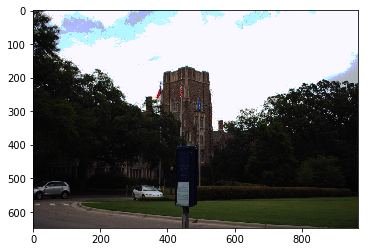

In [64]:
plt.imshow(ref2low[:,:,[2,1,0]])

１．现在的算法中，直方图匹配后把ref图的过曝区域的颜色容易变得不自然，导致后面对occlusion区域填充时、可能会把这些不自然的区域的一部分填充到low_warp里。

２．现在对clipped区域的光流进行插值的方法比较简单粗暴，使用全图平均值进行插值的。

３．当前快速光流算法可能不是太稳定，需要用更多情况的图验证。

# 可能加速的地方

１．参考论文Locally Non-rigid Registration for Mobile HDR Photography
提到在hdr图像的对齐步骤中，光流不用计算的太精确。也许可以用较小尺寸的图像计算光流，然后上采样再做warp

2.merge_mertens方法里可能不需要饱和度那一个参数，而且计算权重图也许可以用较小尺寸的图像计算，再上采样进行融合。如果上采样的权重图在边缘比较模糊，
可以用fast guided filter类似的方法对边缘进行特殊处理，然后再用这样的权重图融合不同曝光的图像。